**load libraries**

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import class_weight, shuffle
from sklearn.model_selection import train_test_split
import shutil
import cv2
import tensorflow as tf
import seaborn as sns
%matplotlib inline
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping,ModelCheckpoint
from tensorflow.keras.layers import Activation, Conv2D, MaxPooling2D,MaxPool2D,AveragePooling2D,GlobalAveragePooling2D,GlobalMaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, AveragePooling2D
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
%%time
data = np.load('image_data.npy')
labels = np.load('label_data.npy')

Wall time: 59.9 s


In [3]:
#shape of array
print("Dimension of image array  : ",data.ndim)
print("Shape of image array : ", data.shape)
print("Dimension of label  : ",labels.ndim)
print("Shape of label : ",labels.shape)

Dimension of image array  :  4
Shape of image array :  (4638, 224, 224, 3)
Dimension of label  :  1
Shape of label :  (4638,)


**declare variable**

In [4]:
split_ratio = 0.2
inp_size = (224,224,3)
batch_size = 32
epoches = 100
lr = 1e-3
seed = 42

**encoding**

In [5]:
lb = LabelBinarizer()
def encode_label(labels):
    """
    Binalizes label in one-to-all fashion
    INPUT
        labels: NumPy array, an array with the labels of the image
    OUTPUT
        Binalized labels NumPy array
    """
    return lb.fit_transform(labels)

def reverse_label_encoding(labels):
    """
    Reverses the binalization of a label
    INPUT
        labels: Binalized NumPy array of image data labels
    OUTPUT
        NumPy array of the original label of the image data
    """    
    return lb.inverse_transform(labels)

labels = encode_label(labels)

In [6]:
labels

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]])

In [7]:
reverse_label_encoding(labels)

array([0, 0, 0, ..., 2, 2, 2])

**split data**

In [8]:
%%time
x_train_full, x_test, y_train_full, y_test = train_test_split(
    data, labels, 
    stratify=labels, 
    test_size = split_ratio, 
    random_state = seed
)
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_full, 
    y_train_full, 
    stratify = y_train_full, 
    test_size = split_ratio,
    random_state = seed
)

Wall time: 1min 42s


**model build**

In [9]:
model = Sequential()

model.add(Conv2D(64, kernel_size = (3, 3),activation='relu',padding = 'Same',input_shape = inp_size))
model.add(MaxPooling2D(pool_size = (2, 2)))

##############################
model.add(Conv2D(128, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), activation = 'relu',padding = 'Same'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

##############################
model.add(Conv2D(512, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Flatten())

##############################
model.add(Dense(4096, activation = 'relu'))
model.add(Activation('relu')) 
model.add(Dropout(0.25))
#Output
model.add(Dense(3, activation='softmax'))

**compile model**

In [10]:
opt = Adam(lr = 0.002, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, decay = 0.01, amsgrad = False)
model.compile(optimizer = opt, loss='categorical_crossentropy', metrics = ['accuracy'])

**callback**

In [11]:
learning_rate_reduction = ReduceLROnPlateau(
    monitor = 'val_loss', 
    patience = 10, 
    verbose = 0, 
    factor = 0.5, 
    min_lr = 0.00001
)
early_stopping = EarlyStopping(
    patience = 10,
    monitor = 'val_loss', 
    mode = 'min',
    restore_best_weights = True, 
    verbose=0
)
mc = ModelCheckpoint(
    'cust/weights', 
    monitor = 'val_loss',
    mode = 'min', 
    verbose = 1, 
    save_best_only = True, 
    save_weights_only = True
)
callbacks_list = [learning_rate_reduction, early_stopping, mc]


**model fit**

In [12]:
%%time
history = model.fit(
    x_train, 
    y_train, 
    epochs = epoches, 
    batch_size = batch_size, 
    validation_data = (x_valid, y_valid),
    callbacks = callbacks_list, 
    verbose = 1
)

Epoch 1/100
93/93 [==============================] - ETA: 0s - loss: 3.3585 - accuracy: 0.5620
Epoch 00001: val_loss improved from inf to 0.64256, saving model to cust\weights
93/93 [==============================] - 797s 9s/step - loss: 3.3585 - accuracy: 0.5620 - val_loss: 0.6426 - val_accuracy: 0.7358
Epoch 2/100
93/93 [==============================] - ETA: 0s - loss: 0.6038 - accuracy: 0.7571
Epoch 00002: val_loss improved from 0.64256 to 0.60881, saving model to cust\weights
93/93 [==============================] - 748s 8s/step - loss: 0.6038 - accuracy: 0.7571 - val_loss: 0.6088 - val_accuracy: 0.7938
Epoch 3/100
93/93 [==============================] - ETA: 0s - loss: 0.5358 - accuracy: 0.7864
Epoch 00003: val_loss improved from 0.60881 to 0.53822, saving model to cust\weights
93/93 [==============================] - 757s 8s/step - loss: 0.5358 - accuracy: 0.7864 - val_loss: 0.5382 - val_accuracy: 0.7628
Epoch 4/100
93/93 [==============================] - ETA: 0s - loss: 0.519

93/93 [==============================] - ETA: 0s - loss: 0.3345 - accuracy: 0.8642
Epoch 00028: val_loss improved from 0.39782 to 0.39749, saving model to cust\weights
93/93 [==============================] - 697s 7s/step - loss: 0.3345 - accuracy: 0.8642 - val_loss: 0.3975 - val_accuracy: 0.8544
Epoch 29/100
93/93 [==============================] - ETA: 0s - loss: 0.3228 - accuracy: 0.8747
Epoch 00029: val_loss improved from 0.39749 to 0.39167, saving model to cust\weights
93/93 [==============================] - 695s 7s/step - loss: 0.3228 - accuracy: 0.8747 - val_loss: 0.3917 - val_accuracy: 0.8598
Epoch 30/100
93/93 [==============================] - ETA: 0s - loss: 0.3245 - accuracy: 0.8716
Epoch 00030: val_loss did not improve from 0.39167
93/93 [==============================] - 677s 7s/step - loss: 0.3245 - accuracy: 0.8716 - val_loss: 0.3921 - val_accuracy: 0.8544
Epoch 31/100
93/93 [==============================] - ETA: 0s - loss: 0.3217 - accuracy: 0.8767
Epoch 00031: val_l

Epoch 57/100
93/93 [==============================] - ETA: 0s - loss: 0.2369 - accuracy: 0.9013
Epoch 00057: val_loss did not improve from 0.37242
93/93 [==============================] - 750s 8s/step - loss: 0.2369 - accuracy: 0.9013 - val_loss: 0.4245 - val_accuracy: 0.8585
Epoch 58/100
93/93 [==============================] - ETA: 0s - loss: 0.2323 - accuracy: 0.9080 
Epoch 00058: val_loss did not improve from 0.37242
93/93 [==============================] - 995s 11s/step - loss: 0.2323 - accuracy: 0.9080 - val_loss: 0.3748 - val_accuracy: 0.8706
Wall time: 20h 43min 23s


**save mdoel**

In [14]:
%%time
model.save('custom.h5')

Wall time: 44.6 s


**evaluate model**

In [15]:
%%time
model.evaluate(x_test, y_test)

29/29 [==============================] - 49s 2s/step - loss: 0.3602 - accuracy: 0.8631
Wall time: 1min 28s


[0.36023595929145813, 0.8631465435028076]

**plot graphs**

In [42]:
def plt_learning_curve(history_, model_name, x_lim_max):
    fig, ax = plt.subplots(figsize=(15,8))
    
    ax.plot(history_.history['accuracy'], color='b', label='training_accuracy')
    ax.plot(history_.history['val_accuracy'], color='r', label='validation_accuracy')
    
    ax.plot(history_.history['loss'], color='g', label='training_loss')
    ax.plot(history_.history['val_loss'], color='y', label='validation_loss')
    
    ax.legend(loc='best', shadow=True)
    ax.set_title(model_name+' Learning Curves')
    plt.xlabel("Epoch")
    plt.ylabel("Loss/Accuracy")
    ax.set_xlim(-5, x_lim_max)
    ax.set_ylim(0,2)
    ax.set_yticks([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4])
    plt.savefig(model_name+' Learning Curves')

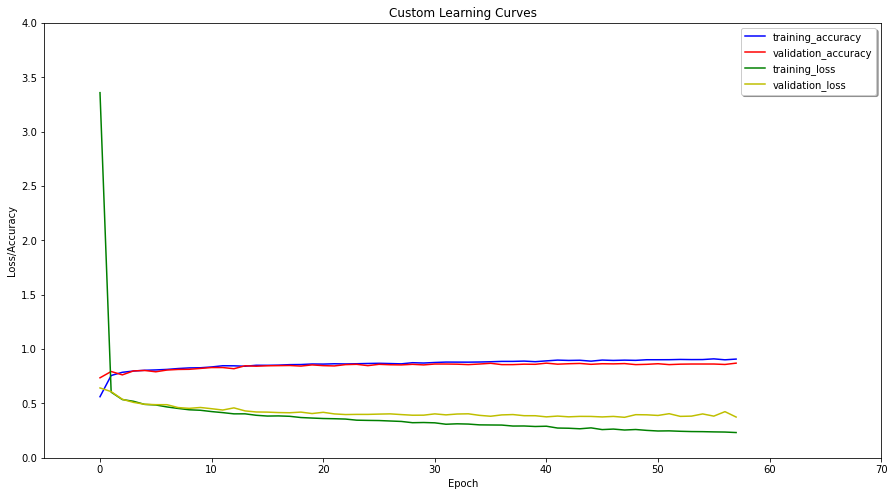

In [43]:
plt_learning_curve(history, 'Custom', 70)

**plot confusion matrix**

In [36]:
%%time
pred = model.predict(x_test, batch_size = batch_size)
pred = np.argmax(pred, axis=1)   
cm = confusion_matrix(y_test.argmax(axis=1), pred)

Wall time: 53.7 s


Accuracy on Test Data: 0.86%
Correct Predictions: 801
Wrong Predictions: 127
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       361
           1       0.75      0.84      0.79       274
           2       0.91      0.75      0.82       293

    accuracy                           0.86       928
   macro avg       0.86      0.85      0.85       928
weighted avg       0.87      0.86      0.86       928

Wall time: 182 ms


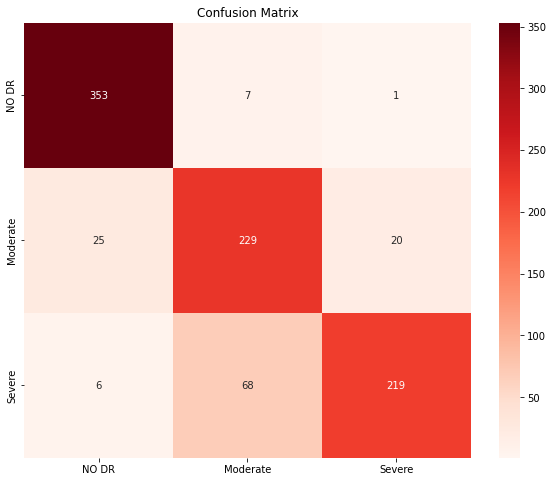

In [39]:
%%time
print('Accuracy on Test Data: %2.2f%%' % (accuracy_score(test, pred)))
fig, ax=plt.subplots(figsize=(10, 8))
classes=['NO DR','Moderate','Severe']
sns.heatmap(cm,annot=True, fmt="d",cmap="Reds", xticklabels=classes, yticklabels=classes)
ax.set_title('Confusion Matrix')
plt.savefig('Confusion Matrix model 3')

correct_pred = int(cm[0][0] + cm[1][1] + cm[2][2])
wrong_pred = len(y_test) - correct_pred

    
print('Correct Predictions:', correct_pred)
print('Wrong Predictions:', wrong_pred)
    
print('----'*20)
print(classification_report(y_test.argmax(axis = 1), pred))